In [23]:
import torch
import os, sys
parent_dir = os.path.abspath('../dct')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
from dct.dct_lee import DCT, IDCT
os.environ['CUDA_VISIBLE_DEVICES']='2'
a = torch.tensor([[[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]]]).cuda()
dct = DCT().cuda()
idct = IDCT().cuda()
b = dct(a)
ab = idct(b)
print(b)
print(ab)

tensor([[[ 9.0000, -3.2212,  0.0000, -0.3367,  0.0000, -0.1005,  0.0000,
          -0.0254],
         [ 9.5000, -1.2691,  0.1913, -0.5836, -1.7678,  0.1598, -0.4619,
           0.7234],
         [12.0000,  1.7947,  1.3066, -0.8253,  0.0000,  0.2260, -0.5412,
          -1.0231]]], device='cuda:0')
tensor([[[ 2.0000,  4.0000,  6.0000,  8.0000, 10.0000, 12.0000, 14.0000,
          16.0000],
         [ 4.0000, 10.0000, 12.0000,  6.0000,  8.0000, 10.0000, 16.0000,
          10.0000],
         [16.0000, 18.0000, 12.0000, 14.0000,  6.0000,  8.0000, 10.0000,
          12.0000]]], device='cuda:0')


In [ ]:
import numpy as np
from scipy.fft import dct as sci_dct
from scipy.fft import idct as sci_idct
aa = np.array([1.,2.,3.,4.,5.,6.,7.,8.])
bb = sci_dct(aa, norm='ortho')
aabb = sci_idct(bb, norm='ortho')
print(bb)
print(aabb)
# match with matlab

In [ ]:
import torch
from dct.discrete_spectral_transform import dct_N
a = torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]]).cuda()
print(a.size())

In [ ]:
b = dct(a)
print(b)

In [ ]:
import torch
a = torch.tensor([[1.,2.,3.,4.,5.,6.,7.,8.],
                  [2.,5.,6.,3.,4.,5.,8.,5.],
                  [8.,9.,6.,7.,3.,4.,5.,6.]])
b = torch.tensor([1.,1.,4.,5.,1.,4.,1.,9.])
print(torch.mul(a,b))

In [ ]:
a = torch.rand((5,3840))#16bins, 256hop
b = torch.stft(a,1024,256,1024,None,True)
c = torch.stft(a,1024,256,1024,None,False)
print(b.size())
print(c.size())

In [81]:
from torch import nn
from torch.nn.functional import pad
from dct.dct_lee import DCT
class MDCT(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'

        self.dct = DCT()

    def forward(self, signal):
        # Pad the signal so that the t-th frame is centered at time t * hop_length. Otherwise, the t-th frame begins at time t * hop_length.
        if self.center:
            signal = pad(signal.to(self.device), (self.win_length//2, 0), mode=self.pad_mode)

        # Pad the signal to a proper length
        signal_len = int(len(signal))
        additional_len = (signal_len-self.win_length)%self.hop_length
        if additional_len:
            pad_len = self.hop_length - additional_len
        else:
            pad_len = 0
        signal = pad(signal, (0,pad_len), mode=self.pad_mode)

        # Slice the signal with overlapping
        signal = signal.unfold(dimension=-1, size=self.win_length, step=self.hop_length)

        # Apply windows to each pieces
        signal = torch.mul(signal.to(self.device), self.window.to(self.device))

        # Pad zeros for DCT
        if self.n_fft > self.win_length:
            signal = pad(signal, (0, self.n_fft-self.win_length), mode='constant')
        return self.dct(signal)

tensor(4.9557e-05)


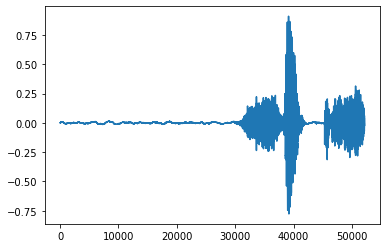

In [113]:
import torchaudio
import matplotlib.pyplot as plt
import torch
import torchaudio.functional as aF
audio_path = '/root/VCTK-Corpus/wav48/p225/p225_003.wav'
audio, fs = torchaudio.load(audio_path)
K = 20000
audio_seg = audio[...,K:51100+1024+K].squeeze()
print(audio_seg.mean())
plt.plot(audio_seg)
plt.show()

torch.Size([1024, 518])
cuda:0


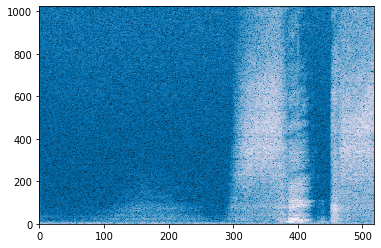

In [114]:
mdct1 = MDCT(n_fft=1024, hop_length=100, win_length=1024, window=torch.kaiser_window, center=True)
spectro_ = mdct1(audio_seg.cuda().squeeze(0)).permute(1,0)
spectro = aF.amplitude_to_DB((spectro_.abs() + 1e-7),20,1e-7,1).squeeze(0)
print(spectro.size())
print(spectro.device)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(spectro.cpu().numpy(), cmap='PuBu_r')
plt.show()

In [ ]:
mdct2 = MDCT(n_fft=256, hop_length=25, win_length=256, window=torch.kaiser_window, center=False)
audio_low = aF.resample(audio_seg,fs,fs/4)
low_spectro = mdct2(audio_low.cuda().squeeze(0)).permute(1,0)
low_spectro = aF.amplitude_to_DB((low_spectro.abs() + 1e-7),20,1e-7,1).squeeze(0)
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(low_spectro.cpu().numpy(), cmap='PuBu_r')
plt.show()

In [ ]:
audio_low_high = aF.resample(audio_low,fs/4,fs)
spectro_low_high = mdct1(audio_low_high.cuda().squeeze(0)).permute(1,0)
spectro_low_high = aF.amplitude_to_DB((spectro_low_high.abs() + 1e-7),20,1e-7,1).squeeze(0)
hr = spectro[:256,:]
hr_min = torch.min(hr)
hr_max = torch.max(hr)
hr = (hr-hr_min)/(hr_max-hr_min)
lr = spectro_low_high[:256,:]
lr_min = torch.min(lr)
lr_max = torch.max(lr)
lr = (lr-lr_min)/(lr_max-lr_min)
print(hr.mean())
print(lr.mean())
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(hr.cpu().numpy(), cmap='PuBu_r')
plt.show()

In [ ]:
diff = (hr-lr).cpu().numpy()
sp_fig, sp_ax = plt.subplots()
sp_ax.pcolormesh(diff, cmap='PuBu_r')
sp_hist_fig, sp_hist_ax = plt.subplots()
sp_hist_ax.hist(diff.reshape(-1,1),bins=100)
plt.show()

In [27]:
x = torch.Tensor([[[  1,  2,  3,  4,  5,  6],
   					[  7,  8,  9,  10, 11, 12],
   					[  13, 14, 15, 16, 17, 18],
   					[  19, 20, 21, 22, 23, 24]]]).transpose_(-1,-2)
fold = nn.Fold(kernel_size=(1,6), stride=(1,2), output_size=(1,12))
print(x)
print(x.size())
x = fold(x)
print(x)
print(x.size())

tensor([[[ 1.,  7., 13., 19.],
         [ 2.,  8., 14., 20.],
         [ 3.,  9., 15., 21.],
         [ 4., 10., 16., 22.],
         [ 5., 11., 17., 23.],
         [ 6., 12., 18., 24.]]])
torch.Size([1, 6, 4])
tensor([[[[ 1.,  2., 10., 12., 27., 30., 45., 48., 38., 40., 23., 24.]]]])
torch.Size([1, 1, 1, 12])


In [28]:
x = torch.Tensor([[[  1,  2,  3,  4,  5,  6],
   					[  7,  8,  9,  10, 11, 12],
   					[  13, 14, 15, 16, 17, 18],
   					[  19, 20, 21, 22, 23, 24]]])
from torch.nn.functional import fold
out_len = (x.size()[-2]-1) * 2 + 6
x = fold(x.transpose_(-1,-2), kernel_size=(1,6), stride=(1,2), output_size=(1,out_len))
print(x)

tensor([[[[ 1.,  2., 10., 12., 27., 30., 45., 48., 38., 40., 23., 24.]]]])


In [83]:
from torch.nn.functional import fold
class IMDCT(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, window=None, center=True, pad_mode='constant', device='cuda') -> None:
        super().__init__()
        self.n_fft = n_fft
        self.pad_mode = pad_mode
        self.device = device
        self.hop_length = hop_length
        self.center = center

        # making window
        if window is None:
            window = torch.ones
        if callable(window):
            self.win_length = int(win_length)
            self.window = window(self.win_length).to(self.device)
        else:
            self.window = window.to(self.device)
            self.win_length = len(window)

        assert self.win_length <= self.n_fft, 'Window lenth %d should be no more than fft length %d'%(self.win_length, self.n_fft)
        assert self.hop_length <= self.win_length, 'You hopped more than one frame'

        self.idct = IDCT()

    def forward(self, signal):
        assert signal.dim() == 3, 'Only tensors shaped in BHW are supported'
        assert signal.size()[-1] == self.n_fft, 'The last dim of input tensor should match the n_fft. Expected %d ,got %d'%(self.n_fft, signal.size()[-1])

        # Inverse transform at the last dim
        signal = self.idct(signal.to(self.device))

        # Remove padded zeros when doing dct
        if self.n_fft > self.win_length:
            signal = signal[...,:self.win_length]

        # Apply windows to each pieces
        signal = torch.mul(signal, self.window)

        # Overlapping adding by fold()
        out_len = (signal.size()[-2]-1) * self.hop_length + self.win_length
        signal = fold(signal.transpose_(-1,-2), kernel_size=(1,self.win_length), stride=(1,self.hop_length), output_size=(1,out_len))

        if self.center:
            # extract the middle part
            signal = signal[..., self.win_length//2:]

        return signal

torch.Size([52212])
tensor(0.0004, device='cuda:0')
tensor(4.4150e-05, device='cuda:0')


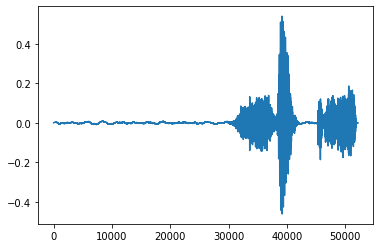

In [116]:
imdct = IMDCT(n_fft=1024, hop_length=100, win_length=1024, window=torch.kaiser_window, center=True)
recover = imdct(spectro_.permute(1,0).unsqueeze(0)).squeeze()
print(recover.size())
print(recover.mean())
recover = recover/(recover.max()-recover.min())
audio_seg = audio_seg/(audio_seg.max()-audio_seg.min())
print(recover.mean())
plt.plot(recover.cpu().numpy())
plt.show()

5.3774133e-06


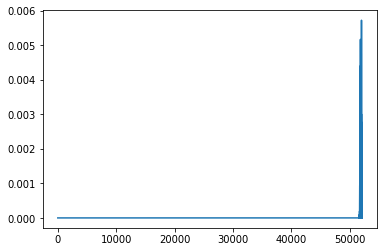

In [121]:
err = torch.pow(recover[:52124].cpu()-audio_seg.cpu(),2).squeeze().numpy()
print(err.mean())
plt.plot(err)
plt.show()